In [1]:
# install tensorflow implementations of EfficientNet with noisy-student weights

!pip install -q efficientnet

In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import efficientnet.tfkeras as efn

from tensorflow.keras.mixed_precision import experimental as mixed_precision
from kaggle_datasets import KaggleDatasets
from tqdm.notebook import tqdm

import unicodedata
import re
import numpy as np
import os
import io
import time
import pickle
import math
import random

In [3]:
# seed everything
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:

# Detect hardware, set appropriate distribution strategy (GPU/TPU)
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on GPU')
    TPU = None

if TPU:
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on TPU  grpc://10.0.0.2:8470
REPLICAS: 8


In [5]:
DEBUG = False

# image resolution
IMG_HEIGHT = 256
IMG_WIDTH = 448
N_CHANNELS = 3
# maximum InChI length is 200 to prevent too much padding
MAX_INCHI_LEN = 200

# batch sizes
BATCH_SIZE_BASE = 6 if DEBUG else (64 if TPU else 12)
BATCH_SIZE = BATCH_SIZE_BASE * REPLICAS
BATCH_SIZE_DEBUG = 2

# target data type, bfloat16 when using TPU to improve throughput
TARGET_DTYPE = tf.float32
 # minimal memory usage of labels
LABEL_DTYPE= tf.uint8

# 100K validation images are used
VAL_SIZE = int(1e3) if DEBUG else int(100e3)
VAL_STEPS = VAL_SIZE // BATCH_SIZE

# ImageNet mean and std to normalize training images accordingly
IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

# Tensorflow AUTO flag, used in datasets
AUTO = tf.data.experimental.AUTOTUNE

In [6]:
# Google Cloud Dataset path to training and validation images
GCS_DS_PATH = KaggleDatasets().get_gcs_path('bmsdata')

In [7]:
# dictionary to translate a character to the integer encoding
with open('/kaggle/input/bmsdata/vocabulary_to_int.pkl', 'rb') as handle:
    vocabulary_to_int = pickle.load( handle)

# dictionary to decode an integer encoded character back to the character
with open('/kaggle/input/bmsdata/int_to_vocabulary.pkl', 'rb') as handle:
    int_to_vocabulary = pickle.load( handle)

In [8]:
# configure model
VOCAB_SIZE = len(vocabulary_to_int.values())
SEQ_LEN_OUT = MAX_INCHI_LEN
DECODER_DIM = 512
CHAR_EMBEDDING_DIM = 456
ATTENTION_UNITS = 456

print(f'VOCAB_SIZE: {VOCAB_SIZE}')

VOCAB_SIZE: 41


In [9]:
# decodes TFRecord
def decode_tfrecord(record_bytes):
    '''
    Input - record_bytes
    output - return images and InChi String
    This function takes record_bytes
    return images and InChi String
    '''
    
    features = tf.io.parse_single_example(record_bytes, 
    {
        'image': tf.io.FixedLenFeature([], tf.string),
        'InChI': tf.io.FixedLenFeature([MAX_INCHI_LEN], tf.int64),
    })

    # decode the PNG and explicitly reshape to image size (required on TPU)
    image = tf.io.decode_png(features['image'])    
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, 1])
    # normalize according to ImageNet mean and std
    image = tf.cast(image, tf.float32)  / 255.0
    image = (image - IMAGENET_MEAN) / IMAGENET_STD

    if TPU: # if running on TPU image needs to be cast to bfloat16
        image = tf.cast(image, TARGET_DTYPE)

    InChI = tf.reshape(features['InChI'], [MAX_INCHI_LEN])
    InChI = tf.cast(InChI, LABEL_DTYPE)

    return image, InChI

In [10]:
# plots the first images of the dataset
def show_batch(dataset, rows=3, cols=2):
    '''
    Input - TFRecords Dataset
    output - Shows the Sample images present in the Dataset
    This function takes Dataset
    return shows the sample images
    '''
    imgs, lbls = next(iter(dataset))
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*7, rows*4))
    for r in range(rows):
        for c in range(cols):
            img = imgs[r*cols+c].numpy().astype(np.float32)
            axes[r, c].imshow(img)

In [11]:
def get_train_dataset(bs=BATCH_SIZE):
    '''
    Input - Batch Size
    output - returns the Training Dataset
    '''
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    
    FNAMES_TRAIN_TFRECORDS = tf.io.gfile.glob(f'{GCS_DS_PATH}/train/*.tfrecords')# .glob is used to find the path for all the TFrecords
    train_dataset = tf.data.TFRecordDataset(FNAMES_TRAIN_TFRECORDS, num_parallel_reads=AUTO)
    train_dataset = train_dataset.with_options(ignore_order)
    train_dataset = train_dataset.prefetch(AUTO) # optimize automatically
    train_dataset = train_dataset.repeat()
    train_dataset = train_dataset.map(decode_tfrecord, num_parallel_calls=AUTO)  # optimize automatically
    train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)# to have same batch size
    train_dataset = train_dataset.prefetch(1) # just 1 prefetched batch is needed
    
    return train_dataset

train_dataset = get_train_dataset()

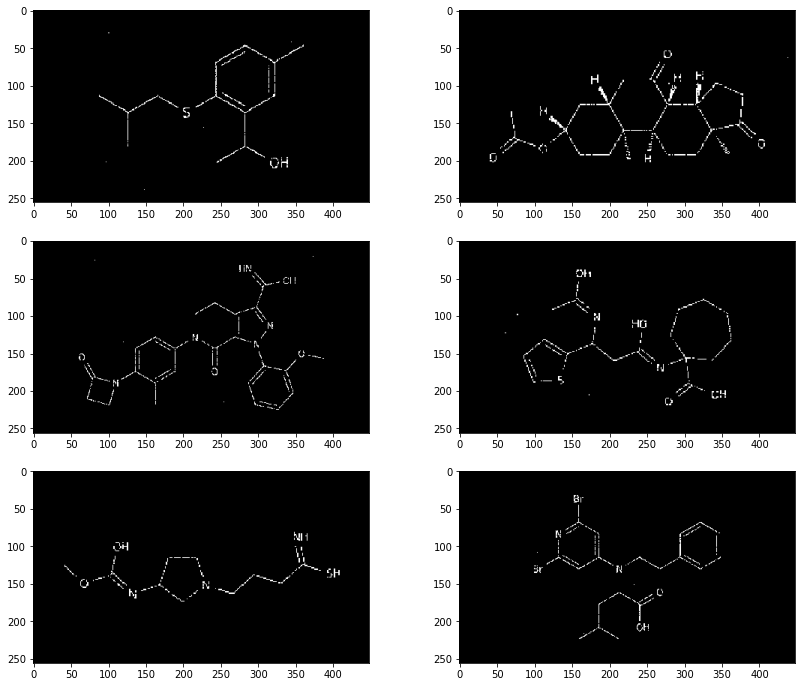

In [12]:
# show first few train images
show_batch(train_dataset)

In [ ]:
def get_val_dataset(bs=BATCH_SIZE):
     '''
    Input - Batch Size
    output - returns the Training Dataset
    '''
    FNAMES_TRAIN_TFRECORDS = tf.io.gfile.glob(f'{GCS_DS_PATH}/val/*.tfrecords')# .glob is used to find the path for all the TFrecords

    val_dataset = tf.data.TFRecordDataset(FNAMES_TRAIN_TFRECORDS, num_parallel_reads=AUTO)
    val_dataset = val_dataset.prefetch(AUTO)# optimize automatically
    val_dataset = val_dataset.repeat()
    val_dataset = val_dataset.map(decode_tfrecord, num_parallel_calls=AUTO)
    val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
    val_dataset = val_dataset.prefetch(1)
    
    return val_dataset

val_dataset = get_val_dataset()

In [15]:
def get_val_dataset(bs=BATCH_SIZE):
    FNAMES_TRAIN_TFRECORDS = tf.io.gfile.glob(f'{GCS_DS_PATH}/val/*.tfrecords')# .glob is used to find the path for all the TFrecords

    val_dataset = tf.data.TFRecordDataset(FNAMES_TRAIN_TFRECORDS, num_parallel_reads=AUTO)
    val_dataset = val_dataset.prefetch(AUTO)# optimize automatically
    val_dataset = val_dataset.repeat()
    val_dataset = val_dataset.map(decode_tfrecord, num_parallel_calls=AUTO)
    val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
    val_dataset = val_dataset.prefetch(1)
    
    return val_dataset

val_dataset = get_val_dataset()

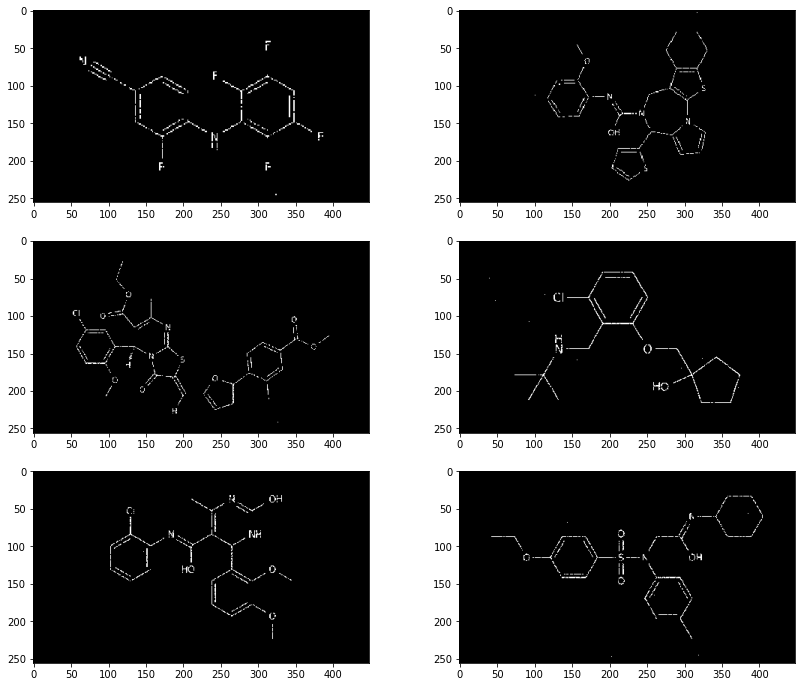

In [16]:
show_batch(val_dataset)

In [17]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        
        # output: (bs, 1280, 14, 8)
        self.feature_maps = efn.EfficientNetB0(include_top=False)
        
        
        # set global encoder dimension variable
        global ENCODER_DIM
        ENCODER_DIM = self.feature_maps.layers[-1].output_shape[-1]
        
        # output: (bs, 1280, 112)
        self.reshape = tf.keras.layers.Reshape([-1, ENCODER_DIM], name='reshape_featuere_maps')

    def call(self, x, training, debug=False):
        x = self.feature_maps(x, training=training)
        if debug:
            print(f'feature maps shape: {x.shape}')
            
        x = self.reshape(x, training=training)
        if debug:
            print(f'feature maps reshaped shape: {x.shape}')
        
        return x

In [18]:
imgs, lbls = next(iter(train_dataset))

In [19]:
# Example enoder output
with tf.device('/CPU:0'):
    encoder = Encoder()
    encoder_res = encoder(imgs[:BATCH_SIZE_DEBUG], debug=True)

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(encoder_res.shape))

16809984/16804768 [==============================] - 0s 0us/step
feature maps shape: (2, 8, 14, 1280)
feature maps reshaped shape: (2, 112, 1280)
Encoder output shape: (batch size, sequence length, units) (2, 112, 1280)


In [20]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.H = tf.keras.layers.Dense(units, name='hidden_to_attention_units')
        self.E = tf.keras.layers.Dense(units, name='encoder_res_to_attention_units')
        self.V = tf.keras.layers.Dense(1, name='score_to_alpha')

    def call(self, h, encoder_res, training, debug=False):
        # dense hidden state to attention units size and expand dimension
        h_expand = tf.expand_dims(h, axis=1) # expand dimension
        if debug:
            print(f'h shape: {h.shape}, encoder_res shape: {encoder_res.shape}')
            print(f'h_expand shape: {h_expand.shape}')
            
        h_dense = self.H(h_expand, training=training)
        
        # dense features to units size
        encoder_res_dense = self.E(encoder_res, training=training) # dense to attention

        # add vectors
        score = tf.nn.relu(h_dense + encoder_res_dense)
        if debug:
            print(f'h_dense shape: {h_dense.shape}')
            print(f'encoder_res_dense shape: {encoder_res_dense.shape}')
            print(f'score tanh shape: {score.shape}')
        score = self.V(score, training=training)
        
        # create alpha vector size (bs, layers)        
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # create attention weights (bs, layers)
        context_vector = encoder_res * attention_weights
    
        # reduce to ENCODER_DIM features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector

In [21]:
with tf.device('/CPU:0'):
    attention_layer = BahdanauAttention(ATTENTION_UNITS)
    context_vector, attention_weights = attention_layer(tf.zeros([BATCH_SIZE_DEBUG, DECODER_DIM]), encoder_res, debug=True)

print('context_vector shape: (batch size, units) {}'.format(context_vector.shape))
print('attention_weights shape: (batch_size, sequence_length, 1) {}'.format(attention_weights.shape))

h shape: (2, 512), encoder_res shape: (2, 112, 1280)
h_expand shape: (2, 1, 512)
h_dense shape: (2, 1, 456)
encoder_res_dense shape: (2, 112, 456)
score tanh shape: (2, 112, 456)
context_vector shape: (batch size, units) (1280,)
attention_weights shape: (batch_size, sequence_length, 1) (1280,)


In [22]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, attention_units, encoder_dim, decoder_dim, char_embedding_dim):
        super(Decoder, self).__init__()
        
        # LSTM hidden and carry state initialization
        self.init_h = tf.keras.layers.Dense(units=decoder_dim, input_shape=[encoder_dim], name='encoder_res_to_hidden_init')
        self.init_c = tf.keras.layers.Dense(units=decoder_dim, input_shape=[encoder_dim], name='encoder_res_to_inp_act_init')
        # The LSTM cell
        self.lstm_cell = tf.keras.layers.LSTMCell(decoder_dim, name='lstm_char_predictor')
        # dropout before prediction
        self.do = tf.keras.layers.Dropout(0.30, name='prediction_dropout')
        # fully connected prediction layer
        self.fcn = tf.keras.layers.Dense(units=vocab_size, input_shape=[decoder_dim], dtype=tf.float32, name='lstm_output_to_char_probs')
        # character embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, char_embedding_dim, name='character_embedding')

        # used for attention
        self.attention = BahdanauAttention(attention_units)

    def call(self, char, h, c, enc_output, training, debug=False):
        if debug:
            print(f'char shape: {char.shape}, h shape: {h.shape}, c shape: {c.shape}, enc_output shape: {enc_output.shape}')
        # embed previous character
        char = self.embedding(char, training=training)
        char = tf.squeeze(char, axis=1)
        if debug:
            print(f'char embedded and squeezed shape: {char.shape}')
        # get attention alpha and context vector
        context = self.attention(h, enc_output, training=training)

        # concat context and char to create lstm input
        lstm_input = tf.concat((context, char), axis=-1)
        if debug:
            print(f'lstm_input shape: {lstm_input.shape}')
        
        # LSTM call, get new h, c
        _, (h_new, c_new) = self.lstm_cell(lstm_input, (h, c), training=training)
        
        # compute predictions with dropout
        output = self.do(h_new, training=training)
        output = self.fcn(output, training=training)

        return output, h_new, c_new
    
    def init_hidden_state(self, encoder_out, training):
        mean_encoder_out = tf.math.reduce_mean(encoder_out, axis=1)
        h = self.init_h(mean_encoder_out, training=training)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out, training=training)
        return h, c

In [23]:
with tf.device('/CPU:0'):
    decoder = Decoder(VOCAB_SIZE, ATTENTION_UNITS, ENCODER_DIM, DECODER_DIM, CHAR_EMBEDDING_DIM)
    h, c = decoder.init_hidden_state(encoder_res[:BATCH_SIZE_DEBUG], training=False)
    preds, h, c = decoder(lbls[:BATCH_SIZE_DEBUG, :1], h, c, encoder_res, debug=True)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(preds.shape))

char shape: (2, 1), h shape: (2, 512), c shape: (2, 512), enc_output shape: (2, 112, 1280)
char embedded and squeezed shape: (2, 456)
lstm_input shape: (2, 1736)
Decoder output shape: (batch_size, vocab size) (2, 41)


In [24]:
# The start/end/pad tokens will be removed from the string when computing the Levenshtein distance
START_TOKEN = tf.constant(vocabulary_to_int.get('<start>'), dtype=tf.int64)
END_TOKEN = tf.constant(vocabulary_to_int.get('<end>'), dtype=tf.int64)
PAD_TOKEN = tf.constant(vocabulary_to_int.get('<pad>'), dtype=tf.int64)

In [25]:

tf.keras.backend.clear_session()

# initialize the model, a dummy call to the encoder and deocder is made to allow the summaries to be printed
with strategy.scope():
    # # set half precision policy
    mixed_precision.set_policy('float32')

    # enable XLA optmizations
    tf.config.optimizer.set_jit(True)

    print(f'Compute dtype: {mixed_precision.global_policy().compute_dtype}')
    print(f'Variable dtype: {mixed_precision.global_policy().variable_dtype}')
    
    # Sparse categorical cross entropy loss is used
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

    def loss_function(real, pred):
        per_example_loss = loss_object(real, pred)

        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=BATCH_SIZE)
    
    # Metrics
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    train_loss = tf.keras.metrics.Sum()
    val_loss = tf.keras.metrics.Sum()


    # Encoder
    encoder = Encoder()
    encoder.build(input_shape=[BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS])
    encoder_res = encoder(imgs[:2], training=False)
    
    # Decoder
    decoder = Decoder(VOCAB_SIZE, ATTENTION_UNITS, ENCODER_DIM, DECODER_DIM, CHAR_EMBEDDING_DIM)
    h, c = decoder.init_hidden_state(encoder_res, training=False)
    preds, h, c = decoder(lbls[:2, :1], h, c, encoder_res, training=False)
    
    # Adam Optimizer
    optimizer = tf.keras.optimizers.Adam()

Compute dtype: float32
Variable dtype: float32


In [26]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, None, None, 1280)  4049564   
_________________________________________________________________
reshape_featuere_maps (Resha multiple                  0         
Total params: 4,049,564
Trainable params: 4,007,548
Non-trainable params: 42,016
_________________________________________________________________


In [27]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_res_to_hidden_init ( multiple                  655872    
_________________________________________________________________
encoder_res_to_inp_act_init  multiple                  655872    
_________________________________________________________________
lstm_char_predictor (LSTMCel multiple                  4605952   
_________________________________________________________________
prediction_dropout (Dropout) multiple                  0         
_________________________________________________________________
lstm_output_to_char_probs (D multiple                  21033     
_________________________________________________________________
character_embedding (Embeddi multiple                  18696     
_________________________________________________________________
bahdanau_attention (Bahdanau multiple                  8185

In [28]:
# Training configuration
EPOCHS = 10
WARMUP_STEPS = 500
TRAIN_STEPS = 1000
VERBOSE_FREQ = 100
STEPS_PER_EPOCH = TRAIN_STEPS // VERBOSE_FREQ
TOTAL_STEPS = EPOCHS * TRAIN_STEPS

In [29]:
def lrfn(step, WARMUP_LR_START, LR_START, LR_FINAL, DECAYS):
    # exponential warmup
    if step < WARMUP_STEPS:
        warmup_factor = (step / WARMUP_STEPS) ** 2
        lr = WARMUP_LR_START + (LR_START - WARMUP_LR_START) * warmup_factor
    # staircase decay
    else:
        power = (step - WARMUP_STEPS) // ((TOTAL_STEPS - WARMUP_STEPS) / (DECAYS + 1))
        decay_factor =  ((LR_START / LR_FINAL) ** (1 / DECAYS)) ** power
        lr = LR_START / decay_factor

    return round(lr, 8)

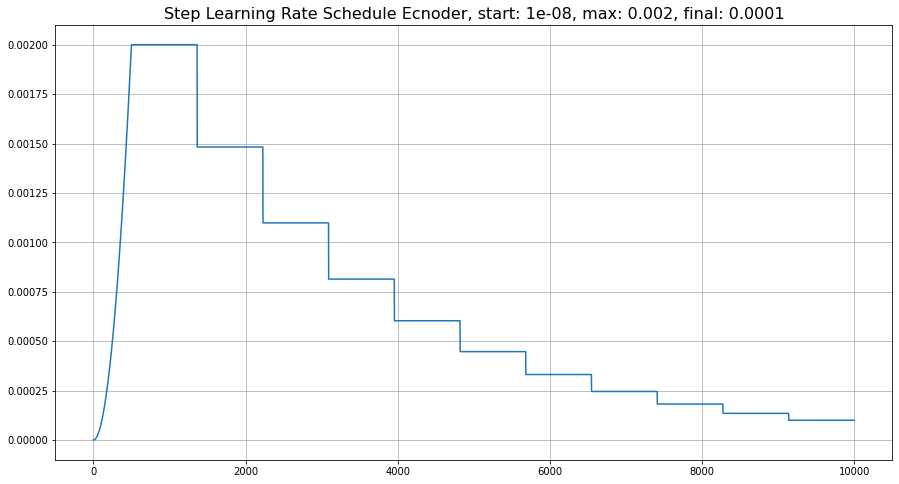

In [30]:
# plot the learning rate schedule
def plot_lr_schedule(lr_schedule, name):
    plt.figure(figsize=(15,8))
    plt.plot(lr_schedule)
    schedule_info = f'start: {lr_schedule[0]}, max: {max(lr_schedule)}, final: {lr_schedule[-1]}'
    plt.title(f'Step Learning Rate Schedule {name}, {schedule_info}', size=16)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, 1e-8, 2e-3, 1e-4 ,EPOCHS) for step in range(TOTAL_STEPS)]
plot_lr_schedule(LR_SCHEDULE, 'Ecnoder')

In [31]:
# converts a dense to a sparse tensor
# sparse tensors are required to compute the Levenshtein distance
def dense_to_sparse(dense):
    ones = tf.ones(dense.shape)
    indices = tf.where(ones)
    values = tf.gather_nd(dense, indices)
    sparse = tf.SparseTensor(indices, values, dense.shape)
    
    return sparse

# computes the levenshtein distance between the predictions and labels
def get_levenshtein_distance(preds, lbls):
    preds = tf.cast(preds, tf.int64)

    preds = tf.where(tf.not_equal(preds, START_TOKEN) & tf.not_equal(preds, END_TOKEN) & tf.not_equal(preds, PAD_TOKEN), preds, y=0)
    
    lbls = strategy.gather(lbls, axis=0)
    lbls = tf.cast(lbls, tf.int64)
    lbls = tf.where(tf.not_equal(lbls, START_TOKEN) & tf.not_equal(lbls, END_TOKEN) & tf.not_equal(lbls, PAD_TOKEN), lbls, y=0)
    
    preds_sparse = dense_to_sparse(preds)
    lbls_sparse = dense_to_sparse(lbls)

    batch_distance = tf.edit_distance(preds_sparse, lbls_sparse, normalize=False)
    mean_distance = tf.math.reduce_mean(batch_distance)
    
    return mean_distance

In [32]:
@tf.function()
def distributed_train_step(dataset):
    # Step function
    def train_step(inp, targ):
        total_loss = 0.0

        with tf.GradientTape() as tape:
            enc_output = encoder(inp, training=True)
            h, c = decoder.init_hidden_state(enc_output, training=True)
            dec_input = tf.expand_dims(targ[:, 0], 1)

            # Teacher forcing - feeding the target as the next input
            for idx in range(1, SEQ_LEN_OUT):
                t = targ[:, idx]
                t = tf.reshape(t, [BATCH_SIZE_BASE])
                # passing enc_output to the decoder
                predictions, h, c = decoder(dec_input, h, c, enc_output, training=True)

                # update loss and train metrics
                total_loss += loss_function(t, predictions)
                train_accuracy.update_state(t, predictions)
                # using teacher forcing
                dec_input = tf.expand_dims(t, 1)

        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(total_loss, variables)
        gradients, _ = tf.clip_by_global_norm(gradients, 10.0)
        optimizer.apply_gradients(zip(gradients, variables))

        batch_loss = total_loss / (SEQ_LEN_OUT - 1)
        train_loss.update_state(batch_loss)
    
    # reset metrics
    train_loss.reset_states()
    train_accuracy.reset_states()
    # perform VERBOSE_FREQ train steps
    for _ in tf.range(tf.convert_to_tensor(VERBOSE_FREQ)):
        strategy.run(train_step, args=next(dataset))

In [40]:
def validation_step(inp, targ):
    total_loss = 0.0
    enc_output = encoder(inp, training=False)
    h, c = decoder.init_hidden_state(enc_output, training=False)
    dec_input = tf.expand_dims(targ[:, 0], 1)

    predictions_seq = tf.expand_dims(targ[:, 0], 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, SEQ_LEN_OUT):
        # passing enc_output to the decoder
        predictions, h, c = decoder(dec_input, h, c, enc_output, training=False)

        # add loss 
        # update loss and train metrics
        total_loss += loss_function(targ[:, t], predictions)
        
        # add predictions to pred_seq
        dec_input = tf.math.argmax(predictions, axis=1, output_type=tf.int32)
        dec_input = tf.expand_dims(dec_input, axis=1)
        dec_input = tf.cast(dec_input, LABEL_DTYPE)
        predictions_seq = tf.concat([predictions_seq, dec_input], axis=1)
        
    batch_loss = total_loss / (SEQ_LEN_OUT - 1)
    val_loss.update_state(batch_loss)
    
    return predictions_seq

In [41]:
@tf.function
def distributed_val_step(dataset):
    inp_val, targ_val = next(dataset)
    per_replica_predictions_seq = strategy.run(validation_step, args=(inp_val, targ_val))
    predictions_seq = strategy.gather(per_replica_predictions_seq, axis=0)
    
    return predictions_seq, targ_val

In [42]:
def get_val_metrics(val_dist_dataset):
    
    # reset metrics
    val_loss.reset_states()
    total_ls_distance = 0.0
    
    for step in range(VAL_STEPS):
        predictions_seq, targ = distributed_val_step(val_dist_dataset)
        levenshtein_distance = get_levenshtein_distance(predictions_seq, targ)
        total_ls_distance += levenshtein_distance
    
    return total_ls_distance / VAL_STEPS


In [43]:
def log(batch, t_start_batch, val_ls_distance=False):
    print(
        f'Step %s|' % f'{batch * VERBOSE_FREQ}/{TRAIN_STEPS}'.ljust(10, ' '),
        f'loss: %.3f,' % (train_loss.result() / VERBOSE_FREQ),
        f'acc: %.3f, ' % train_accuracy.result(),
    end='')
    
    if val_ls_distance:
        print(
            f'val_loss: %.3f, ' % (val_loss.result() / VERBOSE_FREQ),
            f'val lsd: %s,' % ('%.1f' % val_ls_distance).ljust(5, ' '),
        end='')
    # always end with batch duration and line break
    print(
        f'lr: %s,' % ('%.1E' % LRREDUCE.get_lr()).ljust(7),
        f't: %s sec' % int(time.time() - t_start_batch),
    )

In [44]:
class Stats():
    def __init__(self):
        self.stats = {
            'train_loss': [],
            'train_acc': [],
        }
        
    def update_stats(self):
        self.stats['train_loss'].append(train_loss.result() / VERBOSE_FREQ)
        self.stats['train_acc'].append(train_accuracy.result())
        
    def get_stats(self, metric):
        return self.stats[metric]
        
    def plot_stat(self, metric):
        plt.figure(figsize=(15,8))
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.plot(self.stats[metric])
        plt.grid()
        plt.title(f'{metric} stats', size=24)
        plt.show()
        
STATS = Stats()

In [45]:
# custom learning rate scheduler
class LRReduce():
    def __init__(self, optimizer, lr_schedule):
        self.opt = optimizer
        self.lr_schedule = lr_schedule
        # assign initial learning rate
        self.lr = lr_schedule[0]
        self.opt.learning_rate.assign(self.lr)
        
    def step(self, step):
        self.lr = self.lr_schedule[step]
        # assign learning rate to optimizer
        self.opt.learning_rate.assign(self.lr)
        
    def get_counter(self):
        return self.c
    
    def get_lr(self):
        return self.lr
        
LRREDUCE = LRReduce(optimizer, LR_SCHEDULE)

In [47]:
step_total = 0
for epoch in range(EPOCHS):
    print(f'***** EPOCH {epoch + 1} *****')
    
    t_start = time.time()
    t_start_batch = time.time()
    total_loss = 0
    
    # create distributed versions of dataset
    train_dist_dataset = iter(strategy.experimental_distribute_dataset(train_dataset))
    val_dist_dataset = iter(strategy.experimental_distribute_dataset(val_dataset))

    for step in range(1, STEPS_PER_EPOCH + 1):
        # train step
        distributed_train_step(train_dist_dataset)
        STATS.update_stats()
        # save epoch weights
        encoder.save_weights(f'./encoder_epoch_{epoch+1}.h5')
        decoder.save_weights(f'./decoder_epoch_{epoch+1}.h5')
            
        # end of epoch validation
        if step == STEPS_PER_EPOCH:
            val_ls_distance = get_val_metrics(val_dist_dataset)
            # log with validation
            log(step, t_start_batch, val_ls_distance)
        else:
            # normal log
            log(step, t_start_batch)
            # reset start time batch
        t_start_batch = time.time()
            
        total_loss += train_loss.result()
        
        # learning rate step
        LRREDUCE.step(epoch * TRAIN_STEPS + step * VERBOSE_FREQ - 1)
        
        # stop training when NaN loss is detected, this can be caused by exploding gradients
        if np.isnan(total_loss):
            break
            
    # stop training when NaN loss is detected
    if np.isnan(total_loss):
        break

    print(f'Epoch {epoch} Loss {round(total_loss.numpy() / TRAIN_STEPS, 3)}, time: {int(time.time() - t_start)} sec\n')

***** EPOCH 1 *****
Step 100/1000  | loss: 0.274, acc: 0.895, lr: 1.0E-08, t: 40 sec
Step 200/1000  | loss: 0.245, acc: 0.906, lr: 7.8E-05, t: 39 sec
Step 300/1000  | loss: 0.230, acc: 0.912, lr: 3.2E-04, t: 39 sec
Step 400/1000  | loss: 0.223, acc: 0.914, lr: 7.2E-04, t: 39 sec
Step 500/1000  | loss: 0.227, acc: 0.913, lr: 1.3E-03, t: 39 sec
Step 600/1000  | loss: 0.220, acc: 0.915, lr: 2.0E-03, t: 39 sec
Step 700/1000  | loss: 0.202, acc: 0.922, lr: 2.0E-03, t: 39 sec
Step 800/1000  | loss: 0.189, acc: 0.927, lr: 2.0E-03, t: 39 sec
Step 900/1000  | loss: 0.173, acc: 0.934, lr: 2.0E-03, t: 39 sec
Step 1000/1000 | loss: 0.161, acc: 0.939, val_loss: 7.932,  val lsd: 35.6 ,lr: 2.0E-03, t: 127 sec
Epoch 0 Loss 0.214, time: 484 sec

***** EPOCH 2 *****
Step 100/1000  | loss: 0.154, acc: 0.942, lr: 2.0E-03, t: 41 sec
Step 200/1000  | loss: 0.144, acc: 0.946, lr: 2.0E-03, t: 39 sec
Step 300/1000  | loss: 0.137, acc: 0.949, lr: 2.0E-03, t: 39 sec
Step 400/1000  | loss: 0.130, acc: 0.951, lr: 

## Beam Search

In [50]:
#Reference: https://kundan-jha.medium.com/impression-generation-from-x-ray-images-case-study-341d25af6edf#0535-6053f58966b1
def evaluate(image):
    '''
    Input - image 
    output - return InChi String of the images
    This function takes images and using encoder decoder model
    return InChi String of the images
    The function predicts the sentence using beam search
    '''
    
    image_features = encoder(image, training=False)
    H,C = decoder.init_hidden_state(image_features, training=False)

    result = ''
    sequences     = [['<start>', H,C, 0]]

    max_len = 200
    beam_width = 2
    finished_seq = []

    for i in range(max_len):#traverse through all lengths
        new_seq = [] #stores the seq which does not have <end> in them
        all_probable = [] #stores all the top k seq along with their scores
        
        for seq,hidden_state0,hidden_state1,score in sequences: #traverse for all top k sequences
            
            cur_vec = np.reshape(vocabulary_to_int[seq.split(" ")[-1]],(1,1)) 
           # decoder_hidden_state = state
           # x = [cur_vec, image_features, initial_state]
            output, hidden_state0, hidden_state1 =decoder(cur_vec, hidden_state0, hidden_state1, image_features)
            #output,hidden_state,att_weights,context_vector = Attention_model.get_layer('decoder').onestepdecoder(x)
            output = tf.nn.softmax(output)
            top_words = np.argsort(output).flatten()[-beam_width:] #get the top k words
            for index in top_words:
                #here we will update score with log of probabilities and subtracting(log of prob will be in negative)
                #here since its -(log), lower the score higher the prob
                predicted = [seq + ' '+ int_to_vocabulary[index], hidden_state0,hidden_state1, score-np.log(np.array(output).flatten()[index])] #updating the score and seq
                all_probable.append(predicted)

        sequences = sorted(all_probable, key = lambda l: l[-1])[:beam_width] #getting the top 3 sentences with high prob ie low score
        
        count = 0 
        for seq,state0,state1,score in sequences: #check for 'endseq' in each seq in the beam
            if seq.split(" ")[-1] == '<end>': #if last word of the seq is <end>
                score = score/len(seq) #normalizing
                finished_seq.append([seq,state0,state1,score])
                count+=1
            else:
                new_seq.append([seq,state0,state1,score])
        
        sequences = new_seq
        beam_width= beam_width - count #substracting the no. of finished sentences from beam length
        
        if not sequences: #if all the sequences reaches its end
            break        
        else:
            continue

    if len(finished_seq) >0:
          finished_seq = sorted(finished_seq, reverse=True, key = lambda l: l[-1]) # Reverse Sorted the Predicted output by score measure
          sequences = finished_seq[-1] #getting the last predicted output with least probablity score.
          k=0
          for i in finished_seq:
            k+=1
            print('Beam probablity-',i[-1],'Candidate',k,':',i[0]) #printing top k predicted sentence by beam serch and their probablity score
          return sequences[0]


## Beam search Prediction on sample Image

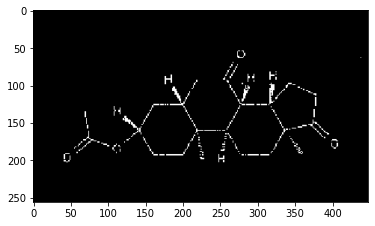

In [56]:
import matplotlib.pyplot as plt
plt.imshow(imgs[1:2][0])

In [63]:
# original InChi
[int2char(p) for p in lbls[1:2].numpy()]

['InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1']

In [ ]:
# converts and integer encoded InChI prediction to a correct InChI string
# Note the "InChI=1S/" part is prepended and all <start>/<end>/<pad> tokens are ignored

END_TOKEN = vocabulary_to_int.get('<end>')
START_TOKEN = vocabulary_to_int.get('<start>')
PAD_TOKEN =  vocabulary_to_int.get('<pad>')

def int2char(i_str):
    res = 'InChI=1S/'
    for i in i_str:
        if i == END_TOKEN:
            return res
        elif i != START_TOKEN and i != PAD_TOKEN:
            res += int_to_vocabulary.get(i)
    return res

In [51]:
# Predicted InChi
evaluate(imgs[1:2])

Beam probablity- 0.024248212334561564 Candidate 1 : <start> C 2 1 H 3 0 O 4 / c 1 - 1 2 ( 2 2 ) 2 5 - 1 4 - 6 - 9 - 2 0 ( 2 ) 1 3 ( 1 1 - 1 4 ) 1 0 - 1 7 ( 2 3 ) 1 9 - 1 5 - 4 - 5 - 1 8 ( 2 4 ) 2 1 ( 1 5 , 3 ) 8 - 7 - 1 6 ( 1 9 ) 2 0 / h 1 3 - 1 6 , 1 9 H , 4 - 1 1 H 2 , 1 - 3 H 3 / t 1 3 - , 1 4 - , 1 5 - , 1 6 - , 1 9 - , 2 0 - , 2 1 - / m 0 / s 1 <end>
Beam probablity- 0.02373634530454099 Candidate 2 : <start> C 2 1 H 3 0 O 4 / c 1 - 1 2 ( 2 2 ) 2 5 - 1 4 - 6 - 9 - 2 0 ( 2 ) 1 3 ( 1 0 - 1 4 ) 1 1 - 1 7 ( 2 3 ) 1 9 - 1 5 - 4 - 5 - 1 8 ( 2 4 ) 2 1 ( 1 5 , 3 ) 8 - 7 - 1 6 ( 1 9 ) 2 0 / h 1 3 - 1 6 , 1 9 H , 4 - 1 1 H 2 , 1 - 3 H 3 / t 1 3 - , 1 4 - , 1 5 - , 1 6 - , 1 9 - , 2 0 - , 2 1 - / m 0 / s 1 <end>


'<start> C 2 1 H 3 0 O 4 / c 1 - 1 2 ( 2 2 ) 2 5 - 1 4 - 6 - 9 - 2 0 ( 2 ) 1 3 ( 1 0 - 1 4 ) 1 1 - 1 7 ( 2 3 ) 1 9 - 1 5 - 4 - 5 - 1 8 ( 2 4 ) 2 1 ( 1 5 , 3 ) 8 - 7 - 1 6 ( 1 9 ) 2 0 / h 1 3 - 1 6 , 1 9 H , 4 - 1 1 H 2 , 1 - 3 H 3 / t 1 3 - , 1 4 - , 1 5 - , 1 6 - , 1 9 - , 2 0 - , 2 1 - / m 0 / s 1 <end>'

In [ ]:
# Decodes the TFRecords to a tuple yielding the image and image_id
@tf.function
def decode_tfrecord_train(record_bytes):
    features = tf.io.parse_single_example(record_bytes, {
        'image': tf.io.FixedLenFeature([], tf.string),
        'image_id': tf.io.FixedLenFeature([], tf.string),
    })

    image = tf.io.decode_png(features['image'])    
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, 1])
    image = tf.cast(image, tf.float32)  / 255.0
    image = (image - IMAGENET_MEAN) / IMAGENET_STD
    image = tf.cast(image, TARGET_DTYPE)
    
    image_id = features['image_id']
    
    return image, image_id

In [ ]:
#  dataset for the test images
def get_test_dataset(bs=BATCH_SIZE):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    
    if TPU:
        FNAMES_TRAIN_TFRECORDS = tf.io.gfile.glob(f'{GCS_DS_PATH}/test/*.tfrecords')
    else:
        FNAMES_TRAIN_TFRECORDS = tf.io.gfile.glob('/kaggle/input/molecular-translation-images-cleaned-tfrecords/test/*.tfrecords')
        
    train_dataset = tf.data.TFRecordDataset(FNAMES_TRAIN_TFRECORDS, num_parallel_reads=AUTO if TPU else cpu_count())
    train_dataset = train_dataset.with_options(ignore_order)
    train_dataset = train_dataset.prefetch(AUTO)
    train_dataset = train_dataset.map(decode_tfrecord_train, num_parallel_calls=AUTO if TPU else cpu_count())
    train_dataset = train_dataset.batch(BATCH_SIZE)
    train_dataset = train_dataset.prefetch(1)
    
    return train_dataset

test_dataset = get_test_dataset()

In [ ]:
START_TOKEN = tf.constant(vocabulary_to_int.get('<start>'), dtype=tf.int32)
END_TOKEN = tf.constant(vocabulary_to_int.get('<end>'), dtype=tf.int32)
PAD_TOKEN = tf.constant(vocabulary_to_int.get('<pad>'), dtype=tf.int32)


## Teacher Forcing Technique

In [ ]:
def prediction_step(imgs):
    # get the feature maps from the encoder
    encoder_res = encoder(imgs)
    # initialize the hidden LSTM states given the feature maps
    h, c = decoder.init_hidden_state(encoder_res,training=False)
    
    # initialize the prediction results with the <start> token
    predictions_seq = tf.fill([len(imgs), 1], value=vocabulary_to_int.get('<start>'))
    predictions_seq = tf.cast(predictions_seq, tf.int32)
    # first encoder input is always the <start> token
    dec_input = tf.expand_dims([vocabulary_to_int.get('<start>')] * len(imgs), 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, SEQ_LEN_OUT):
        # make character prediction and receive new LSTM states
        predictions, h, c = decoder(dec_input, h, c, encoder_res)
        
        # softmax prediction to get prediction classes
        dec_input = tf.math.argmax(predictions, axis=1, output_type=tf.int32)
               
        # expand dimension of prediction to make valid encoder input
        dec_input = tf.expand_dims(dec_input, axis=1)
        
        # add character to predictions
        predictions_seq = tf.concat([predictions_seq, dec_input], axis=1)
            
    return predictions_seq

In [ ]:
# distributed test step, will also run on TPU :D
@tf.function
def distributed_test_step(imgs):
    per_replica_predictions = strategy.run(prediction_step, args=[imgs])
    predictions = strategy.gather(per_replica_predictions, axis=0)
    
    return predictions

In [ ]:
# perform a test step on a single device, used for last batch with random size
@tf.function
def test_step_last_batch(imgs):
    return prediction_step(imgs)


In [ ]:
N_TEST_IMGS = 1616107
N_TEST_STEPS = N_TEST_IMGS // BATCH_SIZE + 1

In [ ]:
# list with predicted InChI's
predictions_inchi = []
# List with image id's
predictions_img_ids = []
# Distributed test set, needed for TPU
test_dist_dataset = strategy.experimental_distribute_dataset(test_dataset)

# Prediction Loop
for step, (per_replica_imgs, per_repliac_img_ids) in tqdm(enumerate(test_dist_dataset), total=N_TEST_STEPS):
    # special step for last batch which has a different size
    # this step will take about half a minute because the function needs to be compiled
    if TPU and step == N_TEST_STEPS - 1:
        imgs_single_device = strategy.gather(per_replica_imgs, axis=0)
        preds = test_step_last_batch(imgs_single_device)
    else:
        # make test step and get predictions
        preds = distributed_test_step(per_replica_imgs)
    
    # get image ids
    img_ids = strategy.gather(per_repliac_img_ids, axis=0)
    
    # decode integer encoded predictions to characters and add to InChI's prediction list
    predictions_inchi += [int2char(p) for p in preds.numpy()]
    # add image id's to list
    predictions_img_ids += [e.decode() for e in img_ids.numpy()]

## This is used for Submitting the result in the competetion.

In [ ]:
# create DataFrame with image ids and predicted InChI's
submission = pd.DataFrame({ 'image_id': predictions_img_ids, 'InChI': predictions_inchi }, dtype='string')
# save as CSV file so we can submit it :D
submission.to_csv('submission.csv', index=False)
# show head of submission, sanity check
pd.options.display.max_colwidth = 200
submission.head()

In [ ]:
! mkdir -p /root/.kaggle/

In [ ]:
! cp ../input/apitoken/kaggle.json /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions submit -c bms-molecular-translation -f submission.csv -m "Message"

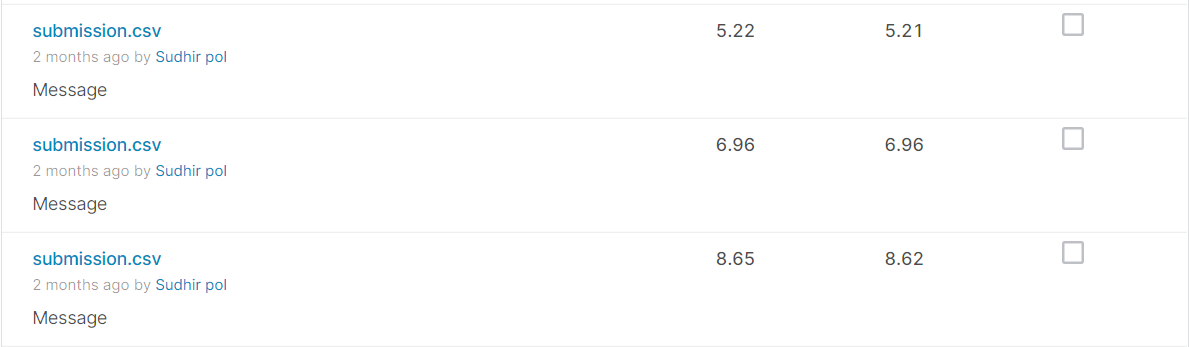

In [1]:
!jupyter nbconvert --to html LSTM_Final_Notebook.ipynb

[NbConvertApp] Converting notebook LSTM_Final_Notebook.ipynb to html
[NbConvertApp] Writing 658645 bytes to LSTM_Final_Notebook.html
